# 对NMOS与PMOS的数学建模

In [1]:
# imports
%matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

import numpy as np
import math
import mpl_interactions.ipyplot as iplt

- $\mu_n=1450cm^2/(V\cdot s)$：硅中电子迁移率
- $C_{ox}$(单位面积的栅氧化层电容) 与栅氧化层厚度成反比 $t_{ox}$, 当$t_{ox}\approx20\dot{A}$,$C_{ox}\approx 17.25fF/\mu m^2$
(引自拉扎维Design of Analog CMOS Integrated Circuits,Second Edition p11)
$$ C_{ox}=\frac{\varepsilon_{ox}}{t_{ox}} $$

## MOS管模型参数定义

### NMOS模型参数

In [2]:
#%%  NMOS模型定义
# % 0.5um Level 1 NMOS SPICE模型

# % 参数定义
# % NMOS模型
# % LEVEL =1 VTO = 0.7 GAMMA = 0.45 PHI = 0.9
# % NSUB = 9e+14 LD = 0.08e-6 UO= 350 LAMBDA = 0.1
# % TOX = 9e-9 PB= 0.9 CJ = 0.56e-3 CJSW = 0.35e-11
# % MJ = 0.45 MJSW = 0.2 CGDO = 0.4e-9 JS= 1.0e-8

class MOS_Electrical_Characteristics:
    V_G = 0       #栅极电位，单位: V
    V_S = 0       #源极电位，单位: V
    V_D = 0       #漏极电位，单位: V
    V_GS = V_G - V_S
    V_DS = V_D - V_S
    
    I_D = 0       #沟道电流，单位：A
    gm = 0        #跨导，单位：A/V
    R_on = 0  #固有电阻，单位：Ohm
    ro = 0    #输出电阻，单位：Ohm
    
    def __init__(self, V_G=0, V_S=0, V_D=0, I_D=0, gm=0, R_on=0, ro=0):
        self.V_G = V_G
        self.V_S = V_S
        self.V_D = V_D
        self.I_D = I_D
        self.gm = gm
        self.R_on = R_on
        self.ro = ro
        
class NMOS_physics:
    MOS_Type = 'NMOS'
    V_T = 0.7    #NMOS沟道电流(threshold voltage of NMOS)   单位: V
    NSUB = 9e14   #衬底掺杂浓度(substrate doping),   单位:cm-3
    UO = 350      #载流子迁移率(channel mobility),   单位:cm2/V/s
    LAMBDA = 0.1   #沟道调制效应系数(channel-length modulation coefficient)  单位:V-1
    GAMMA = 0.45   #体效应系数(body effect coefficient)
    PHI = 0.9      #两倍的费米势
    T_ox = 9e-7    #栅极氧化层厚度  单位：cm
    C_ox = 3.9*8.85e-14 / 9e-7       #栅极氧化层电容  单位：F/cm2
    L = 0.5                        #NMOS沟道长度， 单位: um
    W = 50                         #NMOS栅宽，     单位: um
    L_eff = 0.34                   #NMOS沟道有效长度，取源漏侧扩散长度为0.08um
    
    
    EC = MOS_Electrical_Characteristics()
    

    # 工作区编号，0:截止区， 1：三极管区，  2：饱和区
    working_region = 0
    
    # 二级效应
    channel_length_modulation_considered=False
    
    def __init__(self, name, T_ox=9e-7, W=50, L=0.5):
        self.name = name
        self.T_ox = T_ox
        self.C_ox = 3.9*8.85e-14 / T_ox
        self.W = 50
        self.L = 0.5
        self.L_eff = self.L - 2*0.08
    
    
    #施加栅源、漏源电压
    def Apply_voltage_upon(self, V_G, V_S, V_D):
        self.EC.V_G = V_G
        self.EC.V_S = V_S
        self.EC.V_D = V_D
        self.EC.V_GS = V_G - V_S
        self.EC.V_DS = V_D - V_S
    
    
    #描述
    def Description(self):
        print(f"{self.name}为长为{self.L}um,宽为{self.W}um, V_GS为{self.EC.V_GS},V_DS为{self.EC.V_DS}的NMOS管")


### PMOS模型参数

In [3]:
# % 0.5um Level 1 PMOS SPICE模型

# % PMOS模型
# % LEVEL =1 VTO = -0.8 GAMMA = 0.4 PHI = 0.8
# % PSUB = 5e+14 LD = 0.09e-6 UO= 100 LAMBDA = 0.2
# % TOX = 9e-9 PB= 0.9 CJ = 0.94e-3 CJSW = 0.32e-11
# % MJ = 0.5 MJSW = 0.3 CGDO = 0.3e-9 JS= 0.5e-8
class PMOS_physics:
    MOS_Type = 'PMOS'
    V_T = -0.8    #PMOS沟道电流(threshold voltage of PMOS)   单位: V
    PSUB = 5e14   #衬底掺杂浓度(substrate doping),   单位:cm-3
    UO = 100      #载流子迁移率(channel mobility),   单位:cm2/V/s
    LAMBDA = 0.2   #沟道调制效应系数(channel-length modulation coefficient)  单位:V-1
    GAMMA = 0.4   #体效应系数(body effect coefficient)
    PHI = 0.8      #两倍的费米势
    T_ox = 9e-7    #栅极氧化层厚度  单位：cm
    C_ox = 3.9*8.85e-14 / 9e-7       #栅极氧化层电容  单位：F/cm2
    L = 0.5                        #NMOS沟道长度， 单位: um
    W = 50                         #NMOS栅宽，     单位: um
    L_eff = 0.32                   #NMOS沟道有效长度，取源漏侧扩散长度为0.09um
    
    
    EC = MOS_Electrical_Characteristics()
    
    
    # 工作区编号，0:截止区， 1：三极管区，  2：饱和区
    working_region = 0
    
    # 二级效应
    channel_length_modulation_considered=False
    
    def __init__(self, name, T_ox=9e-7, W=50, L=0.5):
        self.name = name
        self.T_ox = T_ox
        self.C_ox = 3.9*8.85e-14 / T_ox
        self.W = 50
        self.L = 0.5
        self.L_eff = self.L - 2*0.08
    
    
    #施加栅源、漏源电压
    def Apply_voltage_upon(self, V_G, V_S, V_D):
        self.EC.V_G = V_G
        self.EC.V_S = V_S
        self.EC.V_D = V_D
        self.EC.V_GS = V_G - V_S
        self.EC.V_DS = V_D - V_S
    
    
    #描述
    def Description(self):
        print(f"{self.name}为长为{self.L}um,宽为{self.W}um, V_GS为{self.EC.V_GS},V_DS为{self.EC.V_DS}的NMOS管")

In [4]:
#%% 函数定义  
#确定工作区
def Working_region_determine(
    MOS,                   #MOS对象
    message_print=0        #当message_print设定为1时，打印MOS管当前处于的工作区
    ):             
    if MOS.MOS_Type == 'NMOS':
        if MOS.EC.V_GS < MOS.V_T:
            if message_print == 1:
                print(MOS.name,"处于截止区")
            MOS.working_region = 0
        elif MOS.EC.V_GS - MOS.V_T < MOS.EC.V_DS:
            if message_print == 1:
                print(MOS.name,"处于饱和区")
            MOS.working_region = 2
        else:
            if message_print == 1:
                print(MOS.name,"处于三极管区")
            MOS.working_region = 1
    else:
        if MOS.EC.V_GS > MOS.V_T:
            if message_print == 1:
                print(MOS.name,"处于截止区")
            MOS.working_region = 0
        elif MOS.EC.V_GS - MOS.V_T > MOS.EC.V_DS:
            if message_print == 1:
                print(MOS.name,"处于饱和区")
            MOS.working_region = 2
        else:
            if message_print == 1:
                print(MOS.name,"处于三极管区")
            MOS.working_region = 1
    return MOS.working_region

## 体效应与阈值电压：

   $$ V_{TH0}=\Phi_{MS}+2\Phi_F+\frac{Q_{dep}}{C_{ox}} \qquad (2.1) $$

- $Q_{dep}$：耗尽区载流子总数
- $\Phi_{MS}$ ：硅与金属之间的功函数差 
- $q=1.602 × 10^{-19} C$: 电子电荷量

   $$ Q_{dep}=\sqrt{4q\varepsilon_{si}|\Phi_F|N_{sub}} $$

-  $N_{sub}$ ：衬底掺杂浓度
-  $$\varepsilon_{si}=\varepsilon_{r\cdot si}\times\varepsilon_{0}=11.8\times(8.85\times10^{-14})F/cm = 1.0443\times10^{-12}F/cm$$

费米势：
$$    \Phi_F=\frac{kT}{q}ln(\frac{N_{sub}}{n_i})  $$

本征费米能级$E_i$与费米能级$E_F$之差除以电子电荷量q称为P型衬底的费米势$\Phi_{F}$
- $k=1.38\times10^{-23} m^2kgs^{-2}K^{-1}$
- 无论对于NMOS还是PMOS而言，体效应中$V_B$越低，$|V_{TH}|$越高，关系式为

  $$  V_{TH}=V_{TH0}+\gamma(\sqrt{2\Phi_F+V_{SB}}-\sqrt{2|\Phi_F|}) $$



$$ \gamma=\frac{\sqrt{2q\varepsilon_{si}N_{sub}}}{C_{ox}}  $$



In [5]:
def Threshold_Voltage(
    MOS,         #MOS管对象
    VB_def      #衬底电位
    ):
    V_SB = MOS.EC.V_S-VB_def
    print(f"V_SB={V_SB}V")
    if MOS.MOS_Type == 'NMOS':
        MOS.V_T = MOS.V_T + MOS.GAMMA*(math.sqrt(MOS.PHI+V_SB)-math.sqrt(MOS.PHI));
    else:
        MOS.V_T = MOS.V_T - MOS.GAMMA*(math.sqrt(MOS.PHI+V_SB)-math.sqrt(MOS.PHI));

In [6]:
#%% 阈值电压计算
M1 = NMOS_physics('M1')
M1.Apply_voltage_upon(4, 0, 4)
Threshold_Voltage(M1, -1)
print(M1.V_T)
Working_region_determine(M1, message_print=1)

V_SB=1V
0.8933747097213287
M1 处于饱和区


2

## CMOS 大信号模型


$$I_D=\mu_n C_{ox} \frac{W}{L}[(V_{GS}-V_{TH})V_{DS}-\frac{(V_{DS})^2}{2}] \qquad (2.8) $$


$$I_D=\frac{1}{2}\mu_n C_{ox}\frac{W}{L'}(V_{GS}-V_{TH})^2 \qquad (2.13)  $$

设定$I_D$ 从漏极流向源级, 故PMOS中

$$I_D=-\mu_n C_{ox} \frac{W}{L}[(V_{GS}-V_{TH})V_{DS}-\frac{(V_{DS})^2}{2}]$$

$$I_D=-\frac{1}{2}\mu_n C_{ox}\frac{W}{L'}(V_{GS}-V_{TH})^2$$


In [7]:
#计算沟道电流
def Drain_current_culculate(MOS):
    if MOS.MOS_Type == 'NMOS':
        if MOS.working_region == 0:
            MOS.EC.I_D = 0
        elif MOS.working_region == 1:
            MOS.EC.I_D = MOS.UO*MOS.C_ox*(MOS.W/MOS.L_eff)*((MOS.EC.V_GS-MOS.V_T)*MOS.EC.V_DS-MOS.EC.V_DS**2/2);
        else:
            if MOS.channel_length_modulation_considered==False:
                MOS.EC.I_D = ((MOS.UO*MOS.C_ox*(MOS.W/MOS.L_eff)*(MOS.EC.V_GS-MOS.V_T)**2))/2;
            else:
                MOS.EC.I_D = ((MOS.UO*MOS.C_ox*(MOS.W/MOS.L_eff)*(MOS.EC.V_GS-MOS.V_T)**2)*(1+MOS.LAMBDA*MOS.EC.V_DS))/2;
    else:
        if MOS.working_region == 0:
            MOS.EC.I_D = 0
        elif MOS.working_region == 1:
            MOS.EC.I_D = -MOS.UO*MOS.C_ox*(MOS.W/MOS.L_eff)*((MOS.EC.V_GS-MOS.V_T)*MOS.EC.V_DS-MOS.EC.V_DS**2/2);
        else:
            if MOS.channel_length_modulation_considered==False:
                MOS.EC.I_D = -((MOS.UO*MOS.C_ox*(MOS.W/MOS.L_eff)*(MOS.EC.V_GS-MOS.V_T)**2))/2;
            else:
                MOS.EC.I_D = -((MOS.UO*MOS.C_ox*(MOS.W/MOS.L_eff)*(MOS.EC.V_GS-MOS.V_T)**2)*(1+MOS.LAMBDA*MOS.EC.V_DS))/2;
    return MOS.EC.I_D


#绘制转移特性曲线
def Transfer_curve_plot(MOS):
    fig = plt.figure()
    ax = fig.subplots()  # Create a figure and an axes.
    plt.subplots_adjust(left=0.3, bottom=0.25)
    def calculate_ID(V_D, V_G):
        I_D = []
        for i in V_D:
            if MOS.MOS_Type == 'NMOS':
                MOS.Apply_voltage_upon(V_G, 0, i)     
            else:
                MOS.Apply_voltage_upon(V_G, 5, i)     
            Working_region_determine(MOS)
            I_update = Drain_current_culculate(MOS)
            I_D.append(I_update)
        return I_D
    V_D = np.linspace(0,5,100)
    controls = iplt.plot(V_D, calculate_ID, V_G=(0,5,100))
    ax.set_xlabel("沟道电压 V")  # 加入x-label
    ax.set_ylabel('沟道电流 A')  # 加入y-label
    ax.grid()   #加入标尺
    if MOS.MOS_Type == 'NMOS':
        ax.set_ylim(0,0.14)
        ax.set_title("NMOS转移特性曲线")  # 加入标题
    else:
        ax.set_title("PMOS转移特性曲线")  # 加入标题
        ax.set_ylim(-0.06,0)
        
    t1 = ax.text(-0.3, -0.35, 'V_DS = %s'%MOS.EC.V_DS, style='italic', fontsize=12, 
        bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, transform=ax.transAxes)
    t2 = ax.text(-0.3, -0.2, 'V_GS = %s'%MOS.EC.V_GS, style='italic', fontsize=12, 
        bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, transform=ax.transAxes)
    
    def my_callback(V_G):
      t1.set_text('V_DS = %s'%MOS.EC.V_DS)
      t2.set_text('V_GS = %s'%MOS.EC.V_GS)
    controls.register_callback(my_callback, ["V_G"], eager=True)
    


In [8]:
#%% PMOS转移特性曲线实现
M1 = PMOS_physics('M1')
M1.Description()
Transfer_curve_plot(M1)

M1为长为0.5um,宽为50um, V_GS为0,V_DS为0的NMOS管


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [9]:
#%% NMOS实现
M1 = NMOS_physics('M1')
M1.Description()
Transfer_curve_plot(M1)

M1为长为0.5um,宽为50um, V_GS为4,V_DS为4的NMOS管


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## 饱和区输出阻抗(Output impedance)深三极管区的固有电阻(intrinsic resistance)

**饱和区输出阻抗计算公式**
$$   r_O=\frac{\partial V_{DS}}{\partial I_D}  \qquad (2.44)  $$
    
  $$  =\frac{1}{\frac{1}{2}\mu C_{ox} \frac{W}{L} (V_{GS}-V_{TH})^2 \cdot \lambda} \qquad (2.46) $$
    
  $$  = \frac{1+\lambda V_{DS}}{\lambda I_D}\qquad (2.47) $$
    
$$    = \frac{1}{\lambda I_D}    \qquad (2.48) \qquad (\lambda V_{DS}\ll 1)   $$
    

深三极管区的固有电阻为MOSFET输出阻抗的最小值，这可以通过转移特性曲线看的出来

$$R_{on}=\frac{1}{\mu_n C_{ox} \frac{W}{L}(V_{GS}-V_{TH})}  \qquad(2.11) $$


In [10]:
#%% 计算输出阻抗
def Output_impedance(
        MOS,
        equation_number=0      #选择公式，0：式（2.48）；1：式（2.46）
        ):       
    if equation_number == 0:
        MOS.EC.ro = 1/(MOS.LAMBDA*MOS.EC.I_D);      #此式须首先计算出I_D后才能使用
    else:
        MOS.EC.ro = 1/((MOS.LAMBDA*MOS.UO_N*MOS.Cox*(MOS.W/MOS.L_eff)*(MOS.EC.V_GS-MOS.V_T)**2)/2);
    print(f'该MOS管的输出阻抗为{MOS.EC.ro}Ohm')
    return MOS.EC.ro

In [11]:
def Intrinsic_Resistance(MOS):
    MOS.EC.R_on = 1/(MOS.UO*MOS.C_ox*(MOS.W/MOS.L)*(MOS.EC.V_GS-MOS.V_T))
    print(f'该MOS管的固有电阻为{MOS.EC.R_on}Ohm')
    return MOS.EC.R_on

In [12]:
#%% 固有电阻计算
M1 = NMOS_physics('M1')
M1.Apply_voltage_upon(V_G=3, V_S=0, V_D=4)
Working_region_determine(M1)
Drain_current_culculate(M1)
Intrinsic_Resistance(M1)
Output_impedance(M1,equation_number=0)

该MOS管的固有电阻为32.3920736595755Ohm
该MOS管的输出阻抗为191.53573990009863Ohm


191.53573990009863

## MOS饱和区跨导(transconductance)
单位: S(siemens 西门子)
 $$   g_m=\frac{\partial I_D}{\partial V_{GS}} \qquad (2.17)  $$


 $$ g_m=\mu_nC_{ox}\frac{W}{L}(V_{GS}-V_{TH}) \qquad (2.18) $$
 
$g_m$ 也可以表达为:
 $$   g_m=\sqrt{2\mu C_{ox}\frac{W}{L}I_D} \qquad (2.19)  $$
 
    
 $$  g_m = \frac{2I_D}{V_{GS}-V_{TH}} \qquad (2.20)  $$
考虑沟道长度调制效应后：

$$ g_m=\mu_nC_{ox}\frac{W}{L}(V_{GS}-V_{TH})(1+\lambda V_{DS})\\=\sqrt{2\mu C_{ox}\frac{W}{L}I_D(1+\lambda V_{DS})}  $$

该函数可以根据equation_number值的不同选用不同的公式对跨导进行计算

In [13]:
def Transconductaance_calcaulate(MOS,
                                 equation_number=0  #0: 式(2.18)  1:#式(2.19), 2:#式(2.20)
                                 ):
    if MOS.channel_length_modulation_considered==True:
        if equation_number==0:
            MOS.EC.gm = MOS.UO*MOS.C_ox*(MOS.W/MOS.L)*(MOS.EC.V_GS-MOS.V_T)*(1+MOS.LAMBDA*MOS.EC.V_DS); #式(2.18)
        elif equation_number==1:
            MOS.EC.gm = math.sqrt(2*MOS.UO*MOS.C_ox*(MOS.W/MOS.L)*MOS.EC.I_D*(1+MOS.LAMBDA*MOS.EC.V_DS));  #式(2.19)
        else:
            MOS.EC.gm = 2*MOS.EC.I_D/(MOS.EC.V_GS-MOS.V_T);            #式(2.20)'
    else:
        if equation_number==0:
            MOS.EC.gm = MOS.UO*MOS.C_ox*(MOS.W/MOS.L)*(MOS.EC.V_GS-MOS.V_T); #式(2.18)
        elif equation_number==1:
            MOS.EC.gm = math.sqrt(2*MOS.UO*MOS.C_ox*(MOS.W/MOS.L)*MOS.EC.I_D);  #式(2.19)
        else:
            MOS.EC.gm = 2*MOS.EC.I_D/(MOS.EC.V_GS-MOS.V_T);            #式(2.20)'
    return MOS.EC.gm

以书上的习题2.2为例进行建模
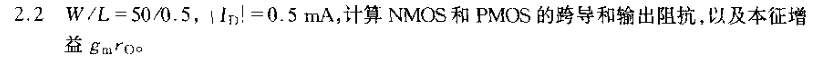
由于本例我们只知道沟道电流，而对各个端口的点位不清楚，故应选择式(2.19)计算跨导

In [15]:
M1 = NMOS_physics('M1')
M1.EC.I_D=0.0005         #0.5mA
gm=Transconductaance_calcaulate(M1,equation_number=1)
print(f'跨导为{gm:.5f}S')
ro = Output_impedance(M1)
A_intr = gm*ro
print(f'本征增益为{A_intr:.3f}')

跨导为0.00366S
该MOS管的输出阻抗为20000.0Ohm
本征增益为73.273
